In [2]:
# !pip install pmdarima

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from  scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import datetime
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# function for mape
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [4]:
df = pd.read_csv('order_fe_status.csv')
df = df[df.grass_date != '9999-01-01']
df.reset_index(inplace=True, drop=True)
df['grass_date']= pd.to_datetime(df['grass_date'])
df2 = df
df = df.set_index(['grass_date'])
df = df.sort_index()
df

,order_fe_status,count
grass_date,,
2015-05-22,CANCELLED,8
2015-05-23,CANCELLED,18
2015-05-24,CANCELLED,1
2015-05-25,COMPLETED,12
2015-05-25,CANCELLED,33
...,...,...
2021-06-19,CANCELLED,273844
2021-06-20,CANCELLED,265075
2021-06-20,TO_PAY,1


In [5]:
df2

,grass_date,order_fe_status,count
0,2021-06-20,COMPLETED,1652168
1,2021-06-20,TO_RECEIVE,10
2,2021-06-20,TO_PAY,1
3,2021-06-20,CANCELLED,265075
4,2021-06-19,CANCELLED,273844
...,...,...,...
5620,2015-05-25,CANCELLED,33
5621,2015-05-25,COMPLETED,12
5622,2015-05-24,CANCELLED,1
5623,2015-05-23,CANCELLED,18


In [6]:
dff = pd.DataFrame()
dff['count'] = df['count'].copy()
dff['status'] = df['order_fe_status']
dff = dff.groupby(['status']).sum().reset_index()
dff

,status,count
0,ALL,30
1,CANCELLED,229169981
2,COMPLETED,1033968957
3,TO_PAY,2155
4,TO_RECEIVE,26042
5,TO_SHIP,221


<AxesSubplot:xlabel='status'>

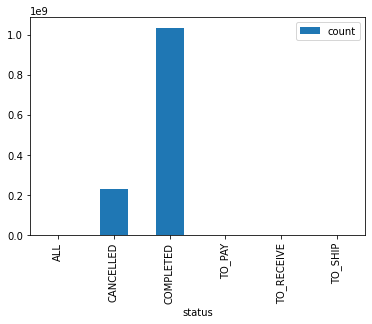

In [7]:
dff.plot.bar(x='status', y='count')

In [8]:
status = ['CANCELLED','COMPLETED']
df_com = df.loc[df['order_fe_status'].isin(status)]
print(df_com)
cancel = df_com[df_com['order_fe_status']=='CANCELLED']
cancel.drop('order_fe_status', axis=1, inplace=True)
cancel.rename(columns={'count':'cancel'}, inplace=True)

complete = df_com[df_com['order_fe_status']=='COMPLETED']
complete.drop('order_fe_status', axis=1, inplace=True)
complete.rename(columns={'count':'complete'}, inplace=True)


           order_fe_status    count
grass_date                         
2015-05-22       CANCELLED        8
2015-05-23       CANCELLED       18
2015-05-24       CANCELLED        1
2015-05-25       COMPLETED       12
2015-05-25       CANCELLED       33
...                    ...      ...
2021-06-18       CANCELLED   282266
2021-06-19       COMPLETED  1956307
2021-06-19       CANCELLED   273844
2021-06-20       CANCELLED   265075
2021-06-20       COMPLETED  1652168

[4368 rows x 2 columns]


C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
df1=pd.DataFrame()
df1['date'] = df_com.index.copy()
df1 = df1.set_index(['date'])
df1['complete'] = complete
df1['cancel'] = cancel
df1.fillna(0, inplace=True)
df1 = df1[df1.index.duplicated(keep='first')]
rate = df1['complete']/(df1['complete']+df1['cancel']) # complete rate calculation
df1['net_rate']=rate
net_rate = df1.drop(['complete','cancel'],axis=1)
net_rate

,net_rate
date,
2015-05-25,0.266667
2015-06-02,0.222222
2015-06-03,0.285714
2015-06-04,0.724138
2015-06-05,0.473684
...,...
2021-06-16,0.864180
2021-06-17,0.891291
2021-06-18,0.888084


In [10]:
net_rate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2146 entries, 2015-05-25 to 2021-06-20
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   net_rate  2146 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB


# Data Visualisation

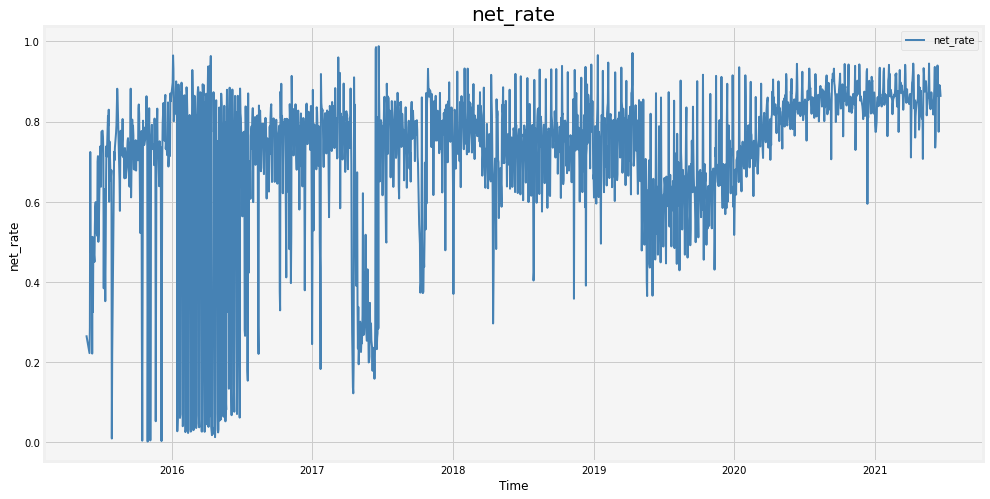

In [11]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(net_rate,label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
#plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

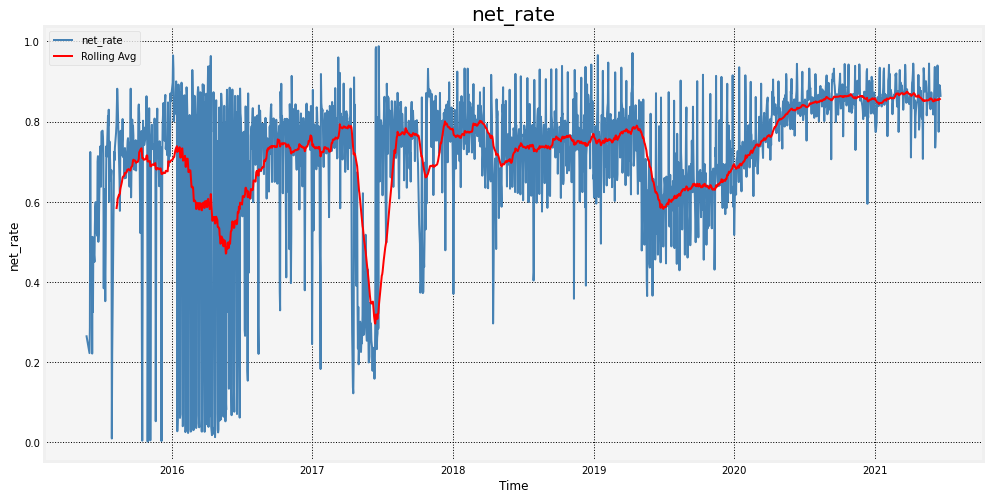

In [12]:
# Rolling Average
df_roll = net_rate.rolling(window=50).mean()

# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(net_rate,label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(df_roll['net_rate'], label = 'Rolling Avg', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

# Exploration Data Analysis (EDA)

C:\Users\mizte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


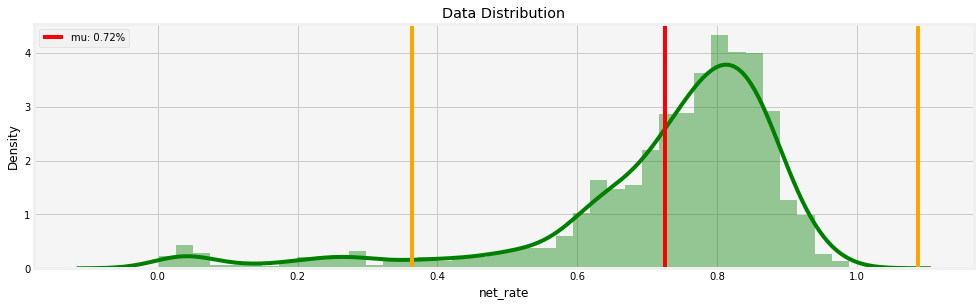

In [13]:
# Plot Distribution

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 4.5) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color

sns.distplot(net_rate['net_rate'],color='g')

plt.title("Data Distribution")
plt.xlabel("net_rate")

mean = np.mean(net_rate['net_rate'])
std = np.std(net_rate['net_rate'])
plt.axvline(x=mean, color='r', linestyle='-', label="mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
# plt.grid(color="k", linestyle=":") # set grid and line shape
plt.legend()
plt.show()

<ipython-input-14-61a0083caa00>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(net_rate, model='additive',freq=30)


Text(0, 0.5, 'seasonal')

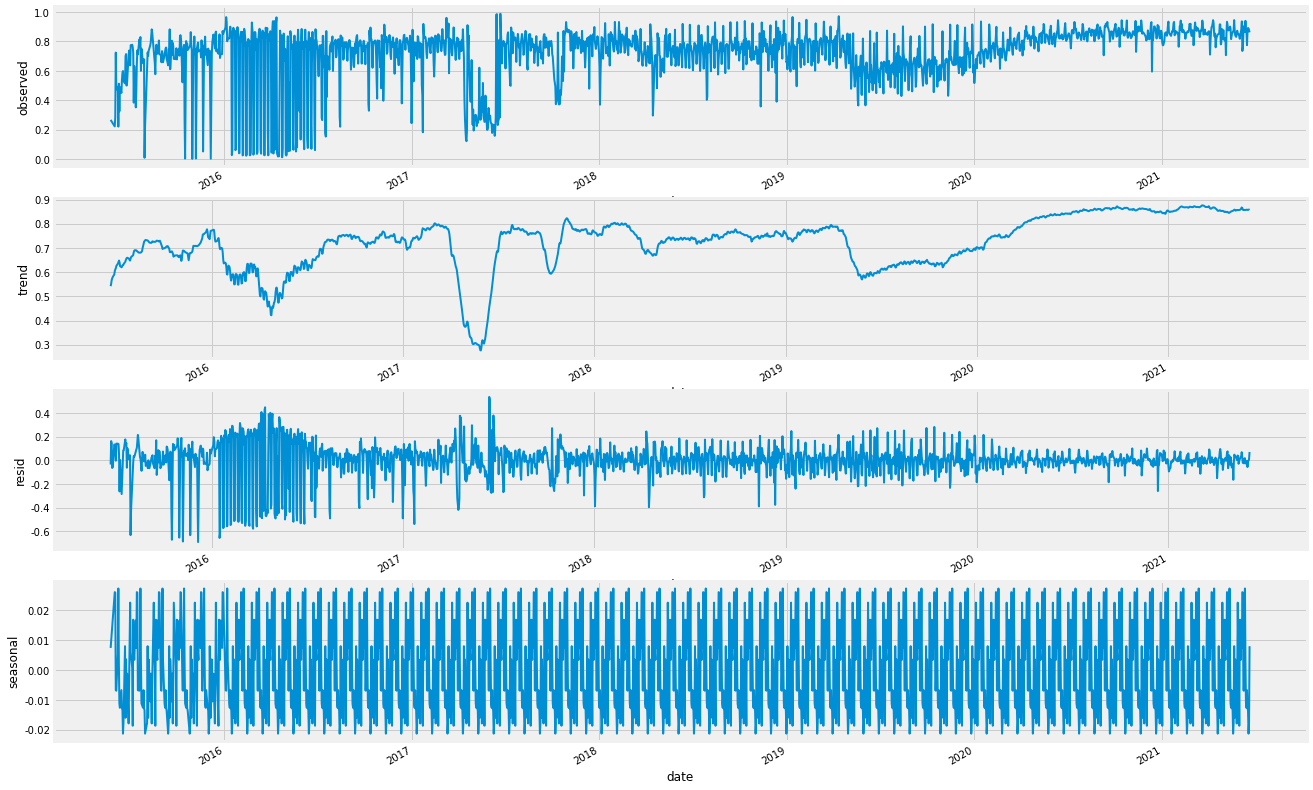

In [14]:
# Data decomposition
res = seasonal_decompose(net_rate, model='additive',freq=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,15))
res.observed.plot(ax=ax1,linewidth=2)
ax1.set_ylabel('observed')
res.trend.plot(ax=ax2,linewidth=2)
ax2.set_ylabel('trend')
res.resid.plot(ax=ax3,linewidth=2)
ax3.set_ylabel('resid')
res.seasonal.plot(ax=ax4,linewidth=2)
ax4.set_ylabel('seasonal')

# Exponential Smoothing

In [15]:
# simple exponential smoothing(one-step-ahead-prediction)
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
def sse(x, y):
    return np.sum(np.power(x-y,2))

alphas = np.arange(0.01,1,0.001)
sse_al = []
for alpha_i in alphas:
  ses_i = net_rate.ewm(alpha = alpha_i, adjust=False).mean()
  sse_al.append(sse(net_rate[1:].values, ses_i[:-1].values))
alpha_opt = alphas[np.argmin(sse_al)]
print(" Optimal Alpha for 1 - step forecast: {:.3f}".format(alpha_opt))

 Optimal Alpha for 1 - step forecast: 0.116


            net_rate  net_rate_exp
date                              
2015-05-25  0.266667      0.266667
2015-06-02  0.222222      0.257778
2015-06-03  0.285714      0.263365
2015-06-04  0.724138      0.355520
2015-06-05  0.473684      0.379153
...              ...           ...
2021-06-15  0.774701      0.851996
2021-06-16  0.864180      0.854433
2021-06-17  0.891291      0.861804
2021-06-18  0.888084      0.867060
2021-06-19  0.877208      0.869090

[2145 rows x 2 columns]


<AxesSubplot:title={'center':'ses vs actual'}, xlabel='date'>

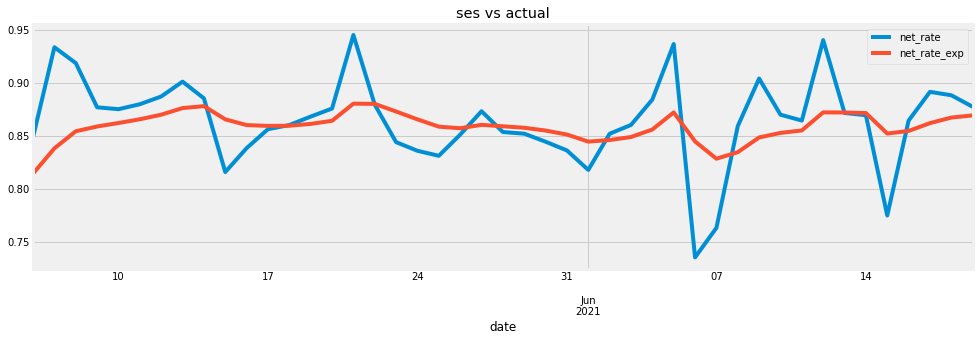

In [16]:
y = net_rate['net_rate'][:len(net_rate)-1]
y = y.reset_index(drop=True)

alpha_opt = 0.2
a = alpha_opt

lt_manual = [y[0]] # l0 = first observation
prediction=[] # obtain prediction values
count=0
for t in range(1,len(y)+1):
    count=count+1
    # Calculate smoothed value at time t
    if t < len(y):
        l_t = a*y[t]+(1-a)*lt_manual[t-1]
        lt_manual.append(l_t)
    else:
        yp=l_t
        pred = a*yp+(1-a)*lt_manual[t-1] # make prediction
        prediction.append(pred)

df2 = net_rate[net_rate.index!='2021-06-20']
df2 = df2.reset_index()
df2['net_rate_exp'] = lt_manual
df2.set_index('date',inplace=True)
print(df2)
df2[2100:].plot(title='ses vs actual')

In [17]:
actual = net_rate['net_rate']['2021-06-20']
d = {'grass_date':'2021-06-20', 'actual': [actual], 'prediction': prediction}
result = pd.DataFrame(d)
result.set_index(['grass_date'], inplace=True)
result

,actual,prediction
grass_date,,
2021-06-20,0.861742,0.86909


# ARIMA

In [18]:
plen = 30
Arima_data = net_rate.copy()
Arima_validation_data = net_rate[-plen:]
Arima_train_data = net_rate[:-plen]

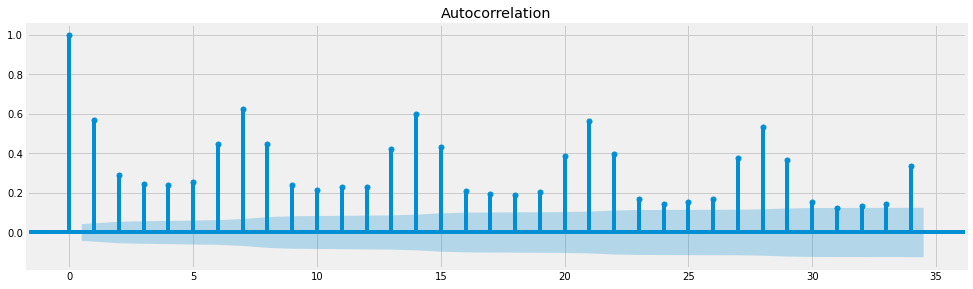

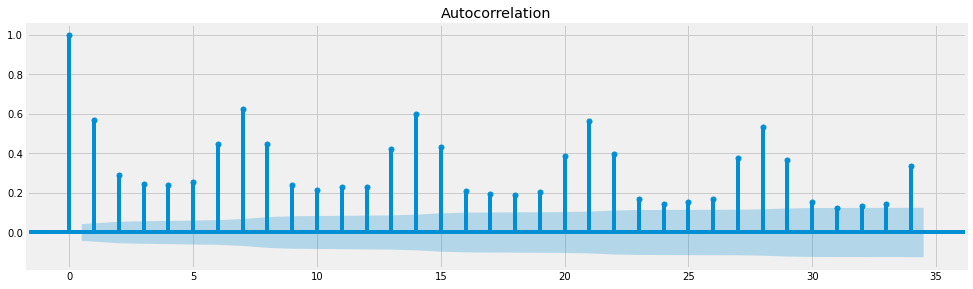

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Arima_data)

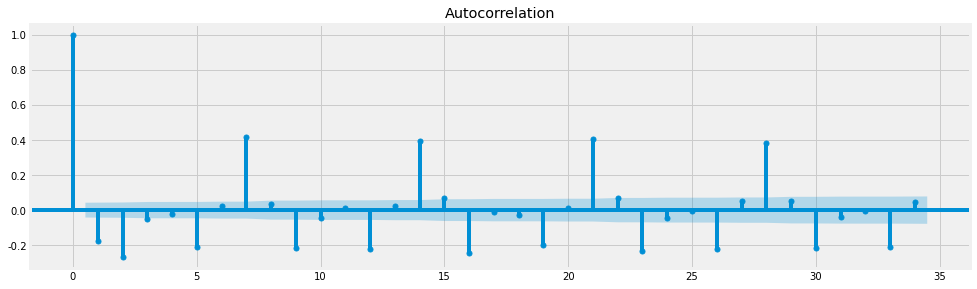

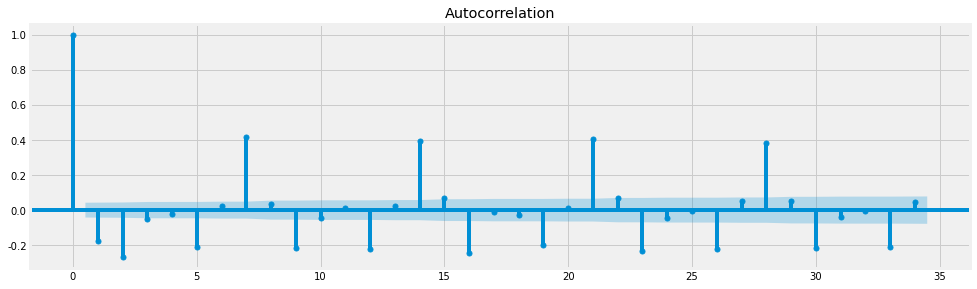

In [20]:
data_diff = Arima_data.diff(periods=1)
data_diff = data_diff[1:]
plot_acf(data_diff) # integrate of order 1, denoted by d(for diff), one of the parameter of ARIMA

In [21]:

stepwise_model = auto_arima(Arima_train_data, start_p=0, start_q=0,
                           max_p=2, max_q=2, m=7,
                           start_P=0,start_Q=0,max_Q=2,max_P=2,seasonal=True,d=1, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1534.931, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-2110.733, Time=1.67 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-2269.895, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1536.923, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-1995.699, Time=0.37 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-2917.700, Time=2.36 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-2446.787, Time=1.23 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-2925.506, Time=5.50 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-2654.205, Time=4.13 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-2917.261, Time=12.31 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-2926.679, Time=15.09 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-2419.671, Time=7.34 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-2336.163, Time=3.18 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=-2949.178, Time=11.67 sec
 ARIMA(1,1,1)(0,

In [22]:
stepwise_model.fit(Arima_train_data)
forecast = stepwise_model.predict(n_periods=len(Arima_validation_data))
forecast = pd.DataFrame(forecast, index = Arima_validation_data.index, columns = ['forecast'])
forecast['actual']=Arima_validation_data
forecast

,forecast,actual
date,,
2021-05-22,0.891235,0.879211
2021-05-23,0.856962,0.843872
2021-05-24,0.855504,0.835711
2021-05-25,0.867444,0.830998
2021-05-26,0.859020,0.850932
2021-05-27,0.871033,0.873001
2021-05-28,0.903052,0.853438
2021-05-29,0.879244,0.851847
2021-05-30,0.854966,0.844284


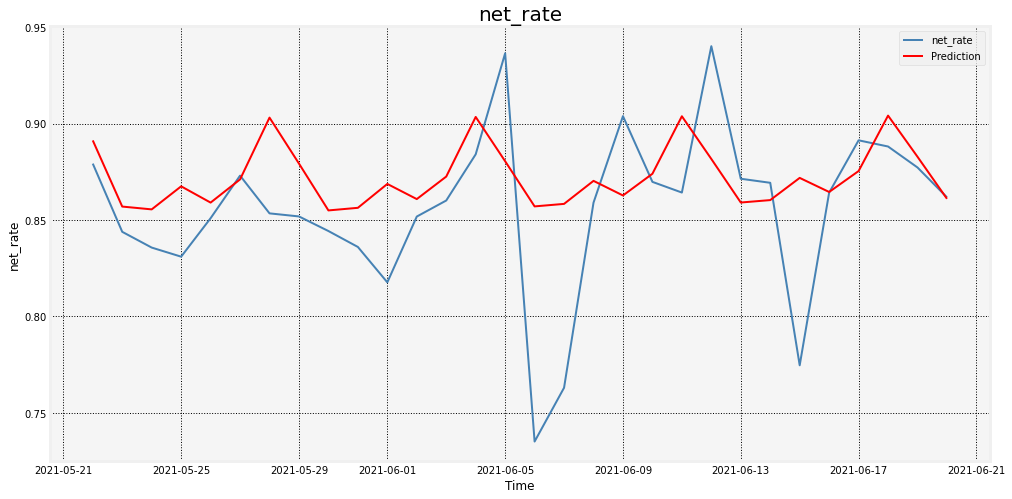

In [23]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

In [24]:
# Metrics

# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.001771
rmse,0.042081
mae,0.029193
mape,3.348336
mdae,0.015966
mdape,1.794542


# Future Prediction with ARIMA

In [25]:
Arima_data = net_rate.copy()
Arima_train_data = net_rate.copy()
Arima_plot_data = net_rate[-14:]

In [26]:

stepwise_model = auto_arima(Arima_train_data, start_p=0, start_q=0,
                           max_p=4, max_q=4, m=7,
                           start_P=0,start_Q=0,max_Q=4,max_P=4,seasonal=True,d=1, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1583.598, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-2166.432, Time=0.77 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-2329.365, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1585.592, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-2051.624, Time=0.35 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-2984.757, Time=2.46 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-2508.509, Time=0.79 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-2932.879, Time=5.17 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-2990.595, Time=11.48 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-2481.245, Time=7.51 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-2985.421, Time=14.21 sec
 ARIMA(0,1,1)(1,0,3)[7] intercept   : AIC=-2960.555, Time=14.88 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=-2571.179, Time=15.24 sec
 ARIMA(0,1,1)(2,0,3)[7] intercept   : AIC=-2984.680, Time=16.45 sec
 ARIMA(0,1,0)(

In [27]:
start_date = datetime.date(2021, 6 , 21)
number_of_days = 20

date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date_list = pd.DataFrame(date_list, columns = ['date'])
date_list # prediction date

,date
0,2021-06-21
1,2021-06-22
2,2021-06-23
3,2021-06-24
4,2021-06-25
5,2021-06-26
6,2021-06-27
7,2021-06-28
8,2021-06-29
9,2021-06-30


In [28]:
stepwise_model.fit(Arima_train_data)
future = stepwise_model.predict(n_periods= number_of_days)
future = pd.DataFrame(future, index = date_list.date, columns = ['future'])
future.index= pd.to_datetime(future.index)
future

,future
date,
2021-06-21,0.848820
2021-06-22,0.842876
2021-06-23,0.866337
2021-06-24,0.873339
2021-06-25,0.884853
2021-06-26,0.889472
2021-06-27,0.844734
2021-06-28,0.844521
2021-06-29,0.842628


<AxesSubplot:title={'center':'Future Net Rate'}, xlabel='date'>

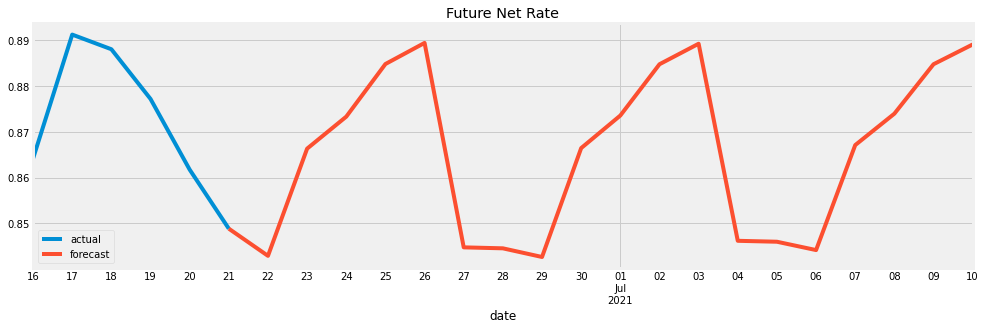

In [29]:
future.rename(columns={'future':'net_rate'}, inplace=True)
Arima_plot = Arima_plot_data.append(future.head(1))
Arima_plot.rename(columns={'net_rate':'actual'}, inplace=True)
future.rename(columns={'net_rate':'forecast'}, inplace=True)
pd.concat([Arima_plot[9:],future],axis=1).plot(title = 'Future Net Rate',figsize=(15, 4.5))

C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


<AxesSubplot:title={'center':'Future Net Rate'}, xlabel='date'>

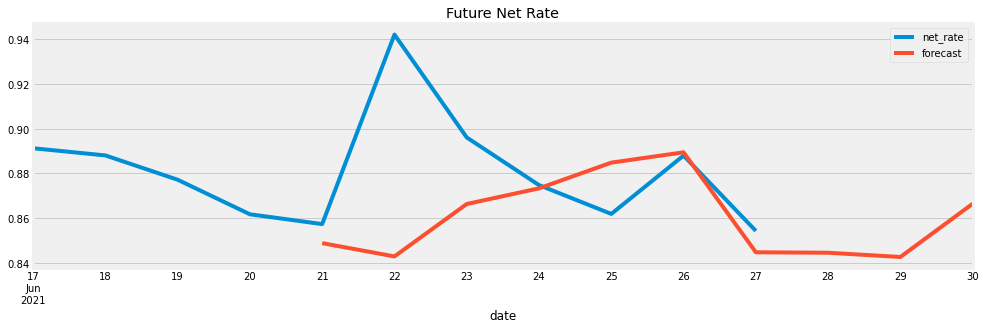

In [30]:
# update data
update = pd.read_csv('order_fe_status_28jun.csv')
update = update[update.grass_date != '9999-01-01']
update.reset_index(inplace=True, drop=True)
update['grass_date']= pd.to_datetime(update['grass_date'])
update = update.set_index(['grass_date'])
update = update.sort_index()

status = ['CANCELLED','COMPLETED']
update_com = update.loc[update['order_fe_status'].isin(status)]
up_cancel = update_com[update_com['order_fe_status']=='CANCELLED']
up_cancel.drop('order_fe_status', axis=1, inplace=True)
up_cancel.rename(columns={'count':'cancel'}, inplace=True)

up_complete = update_com[update_com['order_fe_status']=='COMPLETED']
up_complete.drop('order_fe_status', axis=1, inplace=True)
up_complete.rename(columns={'count':'complete'}, inplace=True)

up1=pd.DataFrame()
up1['date'] = update_com.index.copy()
up1 = up1.set_index(['date'])
up1['complete'] = up_complete
up1['cancel'] = up_cancel
up1.fillna(0, inplace=True)
up1 = up1[up1.index.duplicated(keep='first')]
up_rate = up1['complete']/(up1['complete']+up1['cancel']) # complete rate calculation
up1['net_rate']=up_rate
up_net_rate = up1.drop(['complete','cancel'],axis=1)

pd.concat([up_net_rate[-11:],future[:-10]],axis=1).plot(title = 'Future Net Rate',figsize=(15, 4.5))

# SARIMAX

In [31]:
gmv = pd.read_csv('gmv_vrate_all.csv')
gmv = gmv.drop(['type'],axis=1)
gmv = gmv.rename(columns={'value': 'gmv','grass_date':'date'})
gmv['date']= pd.to_datetime(gmv['date'])
gmv = gmv.set_index(['date'])
gmv = gmv.sort_index()
gmv

,gmv
date,
2019-01-01,0.745626
2019-01-02,0.745626
2019-01-03,0.745626
2019-01-04,0.745626
2019-01-05,0.745626
...,...
2021-06-24,0.782294
2021-06-25,0.783090
2021-06-26,0.786099


In [32]:
ex_net = gmv.copy()
ex_net['net_rate'] = net_rate['net_rate']
ex_net.dropna(inplace=True)
sarimax_data = ex_net.copy()
sarimax_train_data = ex_net[:-plen]
sarimax_val_data = ex_net[-plen:]
sarimax_train_data

,gmv,net_rate
date,,
2019-01-01,0.745626,0.666182
2019-01-02,0.745626,0.610484
2019-01-03,0.745626,0.696556
2019-01-04,0.745626,0.642953
2019-01-05,0.745626,0.788804
...,...,...
2021-05-17,0.779911,0.856119
2021-05-18,0.779858,0.859987
2021-05-19,0.781029,0.867972


In [33]:
stepwise_model_x = auto_arima(sarimax_train_data[['net_rate']],exogenous=sarimax_train_data[['gmv']], start_p=0, start_q=0,
                           max_p=2, max_q=2, m=7,
                           start_P=0,start_Q=0,max_Q=2,max_P=2,seasonal=True,d=1, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_x.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1819.122, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1921.568, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-2107.337, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1821.110, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-2088.083, Time=0.44 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-2180.749, Time=0.95 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-2120.910, Time=0.75 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-2216.896, Time=2.46 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-2201.698, Time=2.25 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-2229.706, Time=5.63 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-2189.700, Time=4.63 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=-2262.966, Time=6.16 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=-2262.700, Time=9.63 sec
 ARIMA(1,1,1)(2,0,1)[7] i

In [34]:
stepwise_model_x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  871
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                1153.689
Date:                           Tue, 29 Jun 2021   AIC                          -2293.378
Time:                                   10:53:35   BIC                          -2259.999
Sample:                                        0   HQIC                         -2280.607
                                           - 871                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gmv            0.2207      0.275      0.801      0.423      -0.319       0.761
ar.L1          0.2274      0.029      7.917      0.000       0.171       0.284
ma.L1         -0.9255      0.012    -78.673      0.000      -0.949      -0.902
ar.S.L7        0.9462      0.037     25.780      0.000       0.874       1.018
ar.S.L14       0.0443      0.035      1.251      0.211      -0.025       0.114
ma.S.L7       -0.9240      0.020    -46.326      0.000      -0.963      -0.885
sigma2         0.0041      0.000     38.898      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1199.26
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Forecast
smodel = SARIMAX(sarimax_train_data['net_rate'], order=(0,1,2), seasonal_order=(2,0,2,7), exog=sarimax_train_data['gmv'])
model_fit = smodel.fit()

C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:title={'center':'Validation Net Rate'}, xlabel='date'>

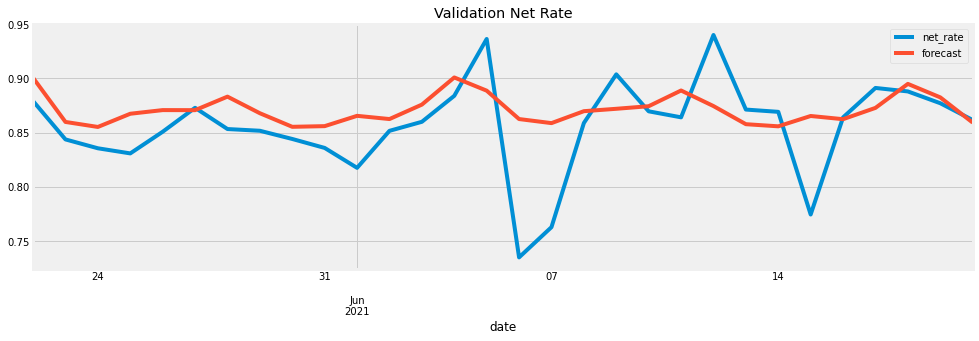

In [36]:
pred_uc = model_fit.get_forecast(steps=len(sarimax_val_data), exog=sarimax_val_data['gmv'])
forecast = pd.DataFrame(pred_uc.predicted_mean)
forecast.index = sarimax_val_data.index
forecast = forecast.rename(columns={'predicted_mean':'forecast'})
pd.concat([sarimax_val_data['net_rate'],forecast],axis=1).plot(title = 'Validation Net Rate',figsize=(15, 4.5))

In [37]:
forecast['actual'] = sarimax_val_data['net_rate']
# Metrics

# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.001674
rmse,0.040914
mae,0.028175
mape,3.240716
mdae,0.017640
mdape,1.986946


# Holt Winters Exponential Smoothing

In [38]:
hw_data = net_rate.copy()
hw_validation_data = net_rate[-plen:]
hw_train_data = net_rate[:-plen]

C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:title={'center':'Validation Net Rate'}, xlabel='date'>

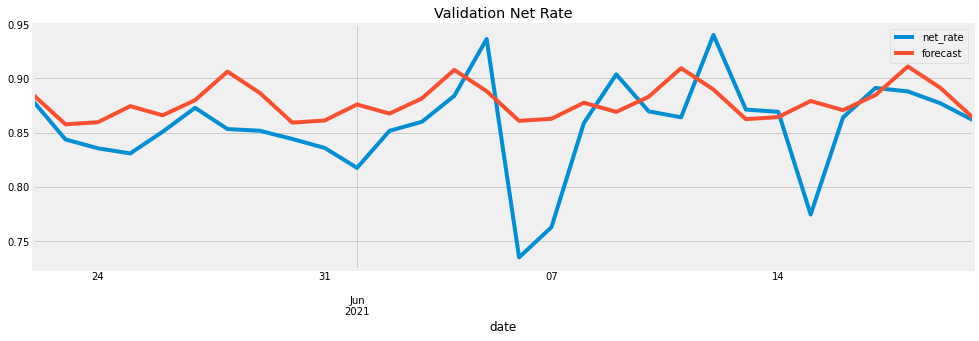

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(hw_train_data,trend='add',
                                    seasonal='add',seasonal_periods=7).fit()
predictions = fitted_model.forecast(len(hw_validation_data)).rename('forecast')
forecast = pd.DataFrame(predictions)
forecast.index = hw_validation_data.index
pd.concat([hw_validation_data['net_rate'],forecast],axis=1).plot(title = 'Validation Net Rate',figsize=(15, 4.5))

In [41]:
forecast['actual'] = hw_validation_data['net_rate']
# Metrics

# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.001960
rmse,0.044273
mae,0.032140
mape,3.661449
mdae,0.022255
mdape,2.545405


# Random Forest Regression

In [61]:
ran_data = net_rate.copy()
ran_val_data = net_rate[-plen:]
ran_train_data = net_rate[:-plen]

In [127]:
# forecast monthly births with random forest
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%f, predicted=%f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# load the dataset
series = ran_data
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, plen)
print('MAE: %.3f' % mae)
# plot expected vs predicted
# pyplot.plot(y, label='Expected')
# pyplot.plot(yhat, label='Predicted')
# pyplot.legend()
# pyplot.show()

>expected=0.879211, predicted=0.879622
>expected=0.843872, predicted=0.854354
>expected=0.835711, predicted=0.846796
>expected=0.830998, predicted=0.842463
>expected=0.850932, predicted=0.826538
>expected=0.873001, predicted=0.857804
>expected=0.853438, predicted=0.863773
>expected=0.851847, predicted=0.836021
>expected=0.844284, predicted=0.840655
>expected=0.836031, predicted=0.847361
>expected=0.817692, predicted=0.832172
>expected=0.851784, predicted=0.827443
>expected=0.860099, predicted=0.867505
>expected=0.884038, predicted=0.855604
>expected=0.936399, predicted=0.902865
>expected=0.735210, predicted=0.870578
>expected=0.763073, predicted=0.782409
>expected=0.858985, predicted=0.780396
>expected=0.903822, predicted=0.847687
>expected=0.869760, predicted=0.876233
>expected=0.864224, predicted=0.850566
>expected=0.940065, predicted=0.785972
>expected=0.871377, predicted=0.874060
>expected=0.869279, predicted=0.856589
>expected=0.774701, predicted=0.857129
>expected=0.864180, predi

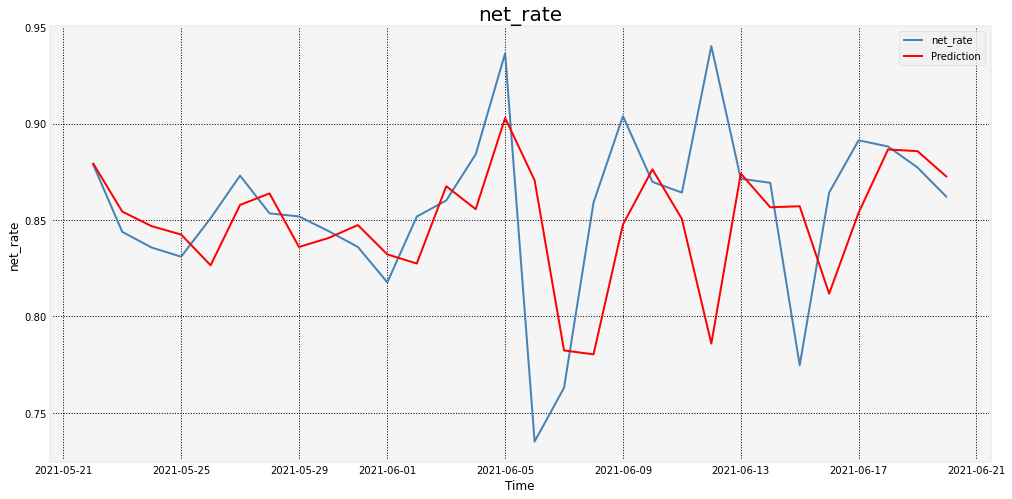

In [128]:
forecast = pd.DataFrame()
forecast['index'] = ran_val_data.index
forecast['forecast'] = yhat
forecast['actual'] = y
forecast = forecast.set_index('index')

# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()
# forecast = pd.concat([ran_val_data.index,y,yhat],axis=1)

# One step ahead prediction with RF

In [138]:
# finalize model and make a prediction for monthly births with random forest
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
 
# load the dataset
series = ran_data
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=7)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values[-7:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print("Inputs: %s" % (row)) # one week prior
print("Tomorrow's predicted value: %f" % (yhat[0]))

Inputs: [0.8692788  0.77470136 0.8641798  0.89129053 0.88808366 0.87720831
 0.86174157]
Tomorrow's predicted value: 0.838985
